# Submission II Time series

* Nama : Irfan Dino
* Asal Kota : Pekanbaru, Riau.

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/content/sample_data/daily-min-temperatures.csv')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [2]:
df.isnull().sum()

Date    0
Temp    0
dtype: int64

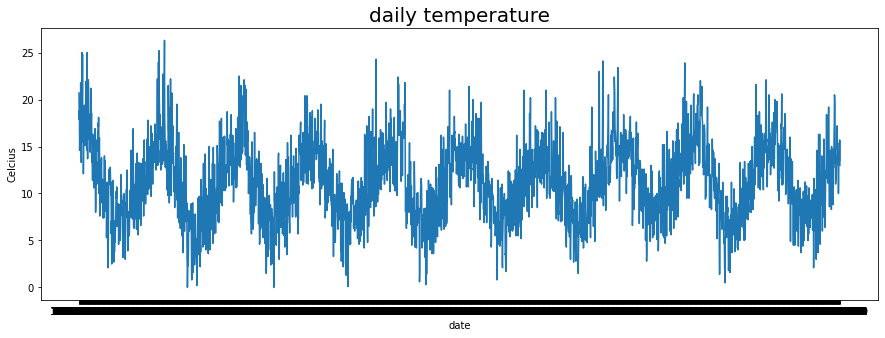

In [3]:
date = df['Date'].values
temp  = df['Temp'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.xlabel('date')
plt.ylabel('Celcius')
plt.title('daily temperature',
          fontsize=20);

In [53]:
from sklearn.model_selection import train_test_split
train_date, val_date, train_temp, val_temp = train_test_split(date, temp, test_size=0.2, shuffle=False)
print(len(train_temp))
print(len(val_temp))

2920
730


In [54]:
temp_train_reshape = train_temp.reshape(-1,1)
temp_val_reshape = val_temp.reshape(-1,1)

In [55]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

scaled_temp_train = min_max_scaler.fit_transform(temp_train_reshape)
scaled_temp_val = min_max_scaler.fit_transform(temp_val_reshape)

In [56]:
temp_train_fix = scaled_temp_train.reshape(2920,)
temp_val_fix = scaled_temp_val.reshape(730,)

In [57]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [58]:
train_set = windowed_dataset(temp_train_fix, window_size=70, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(temp_val_fix, window_size=70, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
])

In [59]:
from re import VERBOSE
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=validation_set, epochs=100,
                    callbacks=[callbacks], verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
29/29 - 10s - loss: 0.0624 - mae: 0.3266 - val_loss: 0.0764 - val_mae: 0.3584 - 10s/epoch - 361ms/step
Epoch 2/100
29/29 - 3s - loss: 0.0493 - mae: 0.2849 - val_loss: 0.0610 - val_mae: 0.3147 - 3s/epoch - 113ms/step
Epoch 3/100
29/29 - 3s - loss: 0.0382 - mae: 0.2448 - val_loss: 0.0493 - val_mae: 0.2771 - 3s/epoch - 116ms/step
Epoch 4/100
29/29 - 3s - loss: 0.0299 - mae: 0.2114 - val_loss: 0.0403 - val_mae: 0.2456 - 3s/epoch - 119ms/step
Epoch 5/100
29/29 - 3s - loss: 0.0239 - mae: 0.1843 - val_loss: 0.0335 - val_mae: 0.2194 - 3s/epoch - 113ms/step
Epoch 6/100
29/29 - 3s - loss: 0.0194 - mae: 0.1628 - val_loss: 0.0284 - val_mae: 0.1984 - 3s/epoch - 113ms/step
Epoch 7/100
29/29 - 3s - loss: 0.0162 - mae: 0.1465 - val_loss: 0.0246 - val_mae: 0.1818 - 3s/epoch - 112ms/step
Epoch 8/100
29/29 - 3s - loss: 0.0139 - mae: 0.1341 - val_loss: 0.0217 - val_mae: 0.1683 - 3s/epoch - 108ms/step
Epoch 9/100
29/29 - 3s - loss: 0.0123 - mae: 0.1246 - val_loss: 0.0195 - val_mae: 0.1578 - 3s/

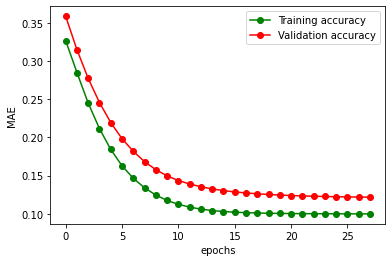

In [60]:
import matplotlib.pyplot as plt

loss=history.history['loss']
mae=history.history['mae']
val_loss=history.history['val_loss']
val_mae=history.history['val_mae']

plt.plot(range(len(mae)), mae, 'g', label='Training accuracy', marker='o')
plt.plot(range(len(mae)), val_mae, 'r', label= 'Validation accuracy', marker='o')
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

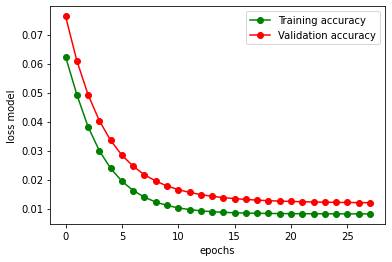

In [61]:
plt.plot(range(len(loss)), loss, 'g', label='Training accuracy', marker='o')
plt.plot(range(len(loss)), val_loss, 'r', label= 'Validation accuracy', marker='o')
plt.xlabel('epochs')
plt.ylabel('loss model')
plt.legend()